<a href="https://colab.research.google.com/github/lovepreetmultani/python/blob/main/HeartFailurePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
heart =pd.read_csv("drive/My Drive/Datasets/heart.csv")
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
heart.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [6]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [7]:
heart.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [8]:
encoded_data=pd.get_dummies(heart, columns = ['Sex','ExerciseAngina','FastingBS','RestingECG','ChestPainType','ST_Slope'],drop_first=True)

In [9]:
encoded_data.shape

(918, 16)

<Axes: >

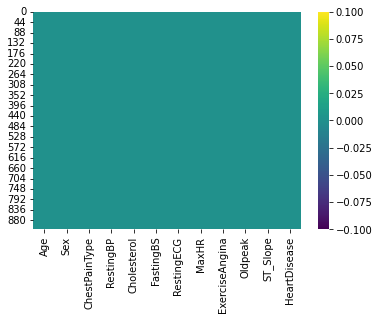

In [10]:
sns.heatmap(heart.isnull(),cbar=True,cmap='viridis')

<Axes: >

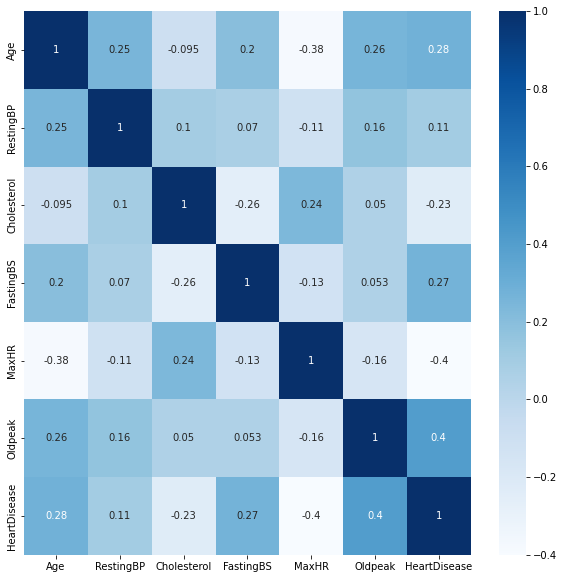

In [11]:
plt.figure(figsize=(10,10))
sns.heatmap(heart.corr(),cbar=True,annot=True,cmap='Blues')

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X=encoded_data.drop('HeartDisease', axis=1)
y=encoded_data['HeartDisease']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 

In [87]:
from sklearn.tree import DecisionTreeClassifier 
import time
from datetime import datetime as dt

In [90]:
dtree=DecisionTreeClassifier(criterion="gini", max_depth=7)

In [91]:
t0 = dt.now()

In [92]:
print("Training time before:", (dt.now()-t0).seconds)

Training time before: 1


In [93]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=7)

In [94]:
#print("Training time:", time.time()-t0)
print("Training time before:", (dt.now()-t0).seconds)

Training time before: 6


In [63]:
pred=dtree.predict(X_test)

In [64]:
pred

array([0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1])

In [109]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score

In [50]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.73      0.79      0.76       118
           1       0.83      0.78      0.81       158

    accuracy                           0.79       276
   macro avg       0.78      0.79      0.78       276
weighted avg       0.79      0.79      0.79       276



In [107]:
print(confusion_matrix(y_test,pred))

[[ 98  20]
 [ 21 137]]


In [52]:
from sklearn import metrics

In [96]:
print("Accuracy:",metrics.accuracy_score(y_test, pred))

Accuracy: 0.8514492753623188


In [102]:
dtree_1 = DecisionTreeClassifier(criterion="entropy", max_depth=7)

In [103]:
#t1 = time.time()
t1 = dt.now()

In [104]:
print("Training time before:", (dt.now()-t1).seconds)
#print("Training time:", time.time()-t1)

Training time before: 1


In [105]:
dtree_1 = dtree_1.fit(X_train,y_train)

In [106]:
print("Training time before:", (dt.now()-t1).seconds)
#print("Training time after:", time.time()-t1)

Training time before: 5


In [33]:
y_pred = dtree_1.predict(X_test)

In [108]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.822463768115942


In [110]:
# calculate precision and recall scores
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

# print the results
print("Precision:", precision)
print("Recall:", recall)

Precision: 0.8219555742267499
Recall: 0.828845741257241


In [35]:
from sklearn.tree import plot_tree 

In [36]:
plt.figure("Decision Tree",figsize=[12,5])
plot_tree=(dtree)
plt.show()

<Figure size 864x360 with 0 Axes>

In [37]:
plot_tree

DecisionTreeClassifier()